Collecting results; computing metrics, making plots

In [1]:
import pickle 
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

from d2c.benchmark import D2CWrapper

from d2c.descriptors.loader import DataLoader

from sklearn.ensemble import RandomForestClassifier



/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = '../data/'

# if any exception write it on disk 

to_dos = []
for file in sorted(os.listdir(root)):
    if file.endswith('.pkl'):
        gen_process_number = int(file.split('_')[0][1:])
        n_variables = int(file.split('_')[1][1:])
        max_neighborhood_size = int(file.split('_')[2][2:])
        noise_std = float(file.split('_')[3][1:-4])
        

        if noise_std != 0.005:
            continue

        if max_neighborhood_size != 8:
            continue

        to_dos.append(file)

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]
to_dos_50_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 50]

In [3]:
def complete_causal_df(causal_df, n_variables, maxlags):
    causal_df = causal_df.copy()
    all_pairs = [(from_, to) for from_ in range(n_variables,n_variables * (maxlags + 1)) for to in range(n_variables)]
    
    existing_pairs = set(zip(causal_df['from'], causal_df['to']))
    missing_pairs = [(from_, to) for from_, to in all_pairs if (from_, to) not in existing_pairs]
    
    # Create all missing rows at once if there are any missing pairs
    if missing_pairs:
        missing_rows = pd.DataFrame(missing_pairs, columns=['from', 'to'])
        missing_rows['effect'] = 0.0
        missing_rows['p-value'] = None
        missing_rows['probability'] = 0.0
        missing_rows['is_causal'] = False
        causal_df = pd.concat([causal_df, missing_rows], ignore_index=True)
    
    return causal_df.sort_values(by=['from', 'to']).reset_index(drop=True)

In [28]:
consider = to_dos_5_variables
consider = to_dos_5_variables+to_dos_10_variables

In [29]:
for file in to_dos_5_variables:
    if file not in os.listdir('./benchmark/'):
        consider.pop(consider.index(file))

In [30]:
# for file in consider:
#     print(file)
#     maxlags = 5

#     with open('./benchmark/'+file, 'rb') as f:
#         causal_dfs_var, causal_dfs_varlingam, causal_dfs_pcmci, causal_dfs_granger, causal_dfs_dynotears, true_causal_dfs = pickle.load(f)
        
#     causal_dfs_varlingam = [complete_causal_df(causal_df, n_variables,maxlags) for causal_df in causal_dfs_varlingam.values()]

#     causal_dfs_varlingam = pd.concat(causal_dfs_varlingam)
#     causal_dfs_var = pd.concat(causal_dfs_var.values())
#     causal_dfs_pcmci = pd.concat(causal_dfs_pcmci.values())
#     causal_dfs_granger = pd.concat(causal_dfs_granger.values())
#     causal_dfs_dynotears = pd.concat(causal_dfs_dynotears.values())
#     true_causal_dfs_competitors = pd.concat(true_causal_dfs)

#     #roc auc score
#     from sklearn.metrics import roc_auc_score, precision_score, recall_score
#     y_hat = causal_dfs_pcmci['is_causal'].astype(int)
#     y_true = true_causal_dfs_competitors['is_causal'].astype(int)
#     print('Precision ', precision_score(y_true, y_hat))
#     print('Recall ', recall_score(y_true, y_hat))

#     with open('./d2c_benchmark/'+file, 'rb') as f:
#         causal_dfs_d2c, true_causal_dfs = pickle.load(f)

#     causal_dfs_d2c = [causal_df.sort_values(by=['from','to']) for causal_df in causal_dfs_d2c.values()]

#     causal_dfs_d2c = pd.concat(causal_dfs_d2c)
#     true_causal_dfs_d2c = pd.concat(true_causal_dfs)

#     assert ((true_causal_dfs_competitors == true_causal_dfs_d2c).all().all())

#     #roc auc score
#     from sklearn.metrics import roc_auc_score, precision_score, recall_score
#     y_prob = causal_dfs_d2c['probability']
#     y_hat = causal_dfs_d2c['is_causal']
#     y_hat = causal_dfs_d2c['probability'] > 0.4

#     y_true = true_causal_dfs_d2c['is_causal']
#     print('D2C ROC ', roc_auc_score(y_true, y_prob))
#     print('D2C Precision ', precision_score(y_true, y_hat))
#     print('D2C Recall ', recall_score(y_true, y_hat))



In [31]:
files_for_sizes = [to_dos_5_variables[0], to_dos_10_variables[0], to_dos_25_variables[0]]

In [32]:
for file in files_for_sizes:
        with open('./benchmark/'+file, 'rb') as f:
                causal_dfs_var, causal_dfs_varlingam, causal_dfs_pcmci, causal_dfs_granger, causal_dfs_dynotears, true_causal_dfs = pickle.load(f)
        print(list(causal_dfs_var.values())[0].shape)

(125, 6)
(500, 6)
(3125, 6)


In [33]:
len(to_dos_10_variables)

18

# Compute absolute metrics

In [34]:
root = '../data/'
destination_root = './benchmark/'
maxlags = 5
predictions = []
# empty folder ../../data/new_benchmark/
scores = pd.DataFrame(columns=['process','n_variables','nj_size','noise','method', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'test_size', 'positive_size'])
for file_idx, file in enumerate(consider):

    
        
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])
    filename = f'{destination_root}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        causal_dfs_var, causal_dfs_varlingam, causal_dfs_pcmci, causal_dfs_granger, causal_dfs_dynotears, true_causal_dfs = pickle.load(f)
        
    causal_dfs_varlingam = [complete_causal_df(causal_df, n_variables,maxlags) for causal_df in causal_dfs_varlingam.values()]
    
    causal_dfs_varlingam = pd.concat(causal_dfs_varlingam)
    causal_dfs_var = pd.concat(causal_dfs_var.values())
    causal_dfs_pcmci = pd.concat(causal_dfs_pcmci.values())
    causal_dfs_granger = pd.concat(causal_dfs_granger.values())
    causal_dfs_dynotears = pd.concat(causal_dfs_dynotears.values())
    true_causal_dfs = pd.concat(true_causal_dfs)

    # assert (causal_dfs_varlingam['from'] == causal_dfs_var['from'] == causal_dfs_pcmci['from'] == causal_dfs_granger['from'] == causal_dfs_dynotears['from'] == true_causal_dfs['from']).all()

    # assert (causal_dfs_varlingam['to'] == causal_dfs_var['to'] == causal_dfs_pcmci['to'] == causal_dfs_granger['to'] == causal_dfs_dynotears['to'] == true_causal_dfs['to']).all()

    y_true = true_causal_dfs['is_causal'].astype(int)
        
    y_pred_var = causal_dfs_var['is_causal'].astype(int)
    y_pred_pcmci = causal_dfs_pcmci['is_causal'].astype(int)
    y_pred_granger = causal_dfs_granger['is_causal'].astype(int)
    y_pred_dynotears = causal_dfs_dynotears['is_causal'].astype(int)
    y_pred_varlingam = causal_dfs_varlingam['is_causal'].astype(int)

    concat_predictions = pd.concat([y_pred_var, y_pred_varlingam, y_pred_pcmci, y_pred_granger, y_pred_dynotears, y_true], axis=1)
    concat_predictions.columns = ['VAR', 'VarLingam', 'PCMCI', 'Granger', 'Dynotears', 'True']

    predictions.append(concat_predictions)

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'VAR', accuracy_score(y_true, y_pred_var), balanced_accuracy_score(y_true, y_pred_var), precision_score(y_true, y_pred_var,zero_division=np.nan), recall_score(y_true, y_pred_var,zero_division=np.nan), f1_score(y_true, y_pred_var,zero_division=np.nan), len(y_true), y_true.sum()]

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'PCMCI', accuracy_score(y_true, y_pred_pcmci), balanced_accuracy_score(y_true, y_pred_pcmci), precision_score(y_true, y_pred_pcmci,zero_division=np.nan), recall_score(y_true, y_pred_pcmci,zero_division=np.nan), f1_score(y_true, y_pred_pcmci,zero_division=np.nan), len(y_true), y_true.sum()]

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'Granger', accuracy_score(y_true, y_pred_granger), balanced_accuracy_score(y_true, y_pred_granger), precision_score(y_true, y_pred_granger,zero_division=np.nan), recall_score(y_true, y_pred_granger,zero_division=np.nan), f1_score(y_true, y_pred_granger,zero_division=np.nan), len(y_true), y_true.sum()]

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'Dynotears', accuracy_score(y_true, y_pred_dynotears), balanced_accuracy_score(y_true, y_pred_dynotears), precision_score(y_true, y_pred_dynotears,zero_division=np.nan), recall_score(y_true, y_pred_dynotears,zero_division=np.nan), f1_score(y_true, y_pred_dynotears,zero_division=np.nan), len(y_true), y_true.sum()]

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'VarLingam', accuracy_score(y_true, y_pred_varlingam), balanced_accuracy_score(y_true, y_pred_varlingam), precision_score(y_true, y_pred_varlingam,zero_division=np.nan), recall_score(y_true, y_pred_varlingam,zero_division=np.nan), f1_score(y_true, y_pred_varlingam,zero_division=np.nan), len(y_true), y_true.sum()]


In [35]:
# load d2c results (they are separate) 

root = './data/'
destination_root = './d2c_benchmark/'

# scores = pd.DataFrame(columns=['process','n_variables','nj_size','noise','method', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'test_size', 'positive_size'])
d2c_prediction = []
for file_idx, file in enumerate(consider):

    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])
    filename = f'{destination_root}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
    if not os.path.exists(filename):
        continue
    
    with open(filename, 'rb') as f:
        causal_dfs_d2c, true_causal_dfs = pickle.load(f)

    causal_dfs_d2c = [causal_df.sort_values(by=['from','to']) for causal_df in causal_dfs_d2c.values()]

    causal_dfs_d2c = pd.concat(causal_dfs_d2c)
    true_causal_dfs = pd.concat(true_causal_dfs)

    y_true = true_causal_dfs['is_causal'].astype(int)
    # y_pred_d2c = causal_dfs_d2c['is_causal'].astype(int)
    y_pred_d2c_035 = causal_dfs_d2c['probability'] > 0.35
    y_pred_d2c_050 = causal_dfs_d2c['probability'] > 0.50
    y_pred_d2c_065 = causal_dfs_d2c['probability'] > 0.65
    # concat_prediction = pd.concat([y_pred_d2c, y_true], axis=1)
    # concat_prediction.columns = ['D2C', 'TrueD2C']
    # d2c_prediction.append(concat_prediction)

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'D2C t=0.35', accuracy_score(y_true, y_pred_d2c_035), balanced_accuracy_score(y_true, y_pred_d2c_035), precision_score(y_true, y_pred_d2c_035), recall_score(y_true, y_pred_d2c_035), f1_score(y_true, y_pred_d2c_035), len(y_true), y_true.sum()]

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'D2C t=0.50', accuracy_score(y_true, y_pred_d2c_050), balanced_accuracy_score(y_true, y_pred_d2c_050), precision_score(y_true, y_pred_d2c_050), recall_score(y_true, y_pred_d2c_050), f1_score(y_true, y_pred_d2c_050), len(y_true), y_true.sum()]

    scores.loc[len(scores)] = [gen_process_number,n_variables, max_neighborhood_size, noise_std, 'D2C t=0.65', accuracy_score(y_true, y_pred_d2c_065), balanced_accuracy_score(y_true, y_pred_d2c_065), precision_score(y_true, y_pred_d2c_065), recall_score(y_true, y_pred_d2c_065), f1_score(y_true, y_pred_d2c_065), len(y_true), y_true.sum()]

    


In [36]:
scores.to_csv('scores_no_filter_mixed_no_standardization.csv', index=False)

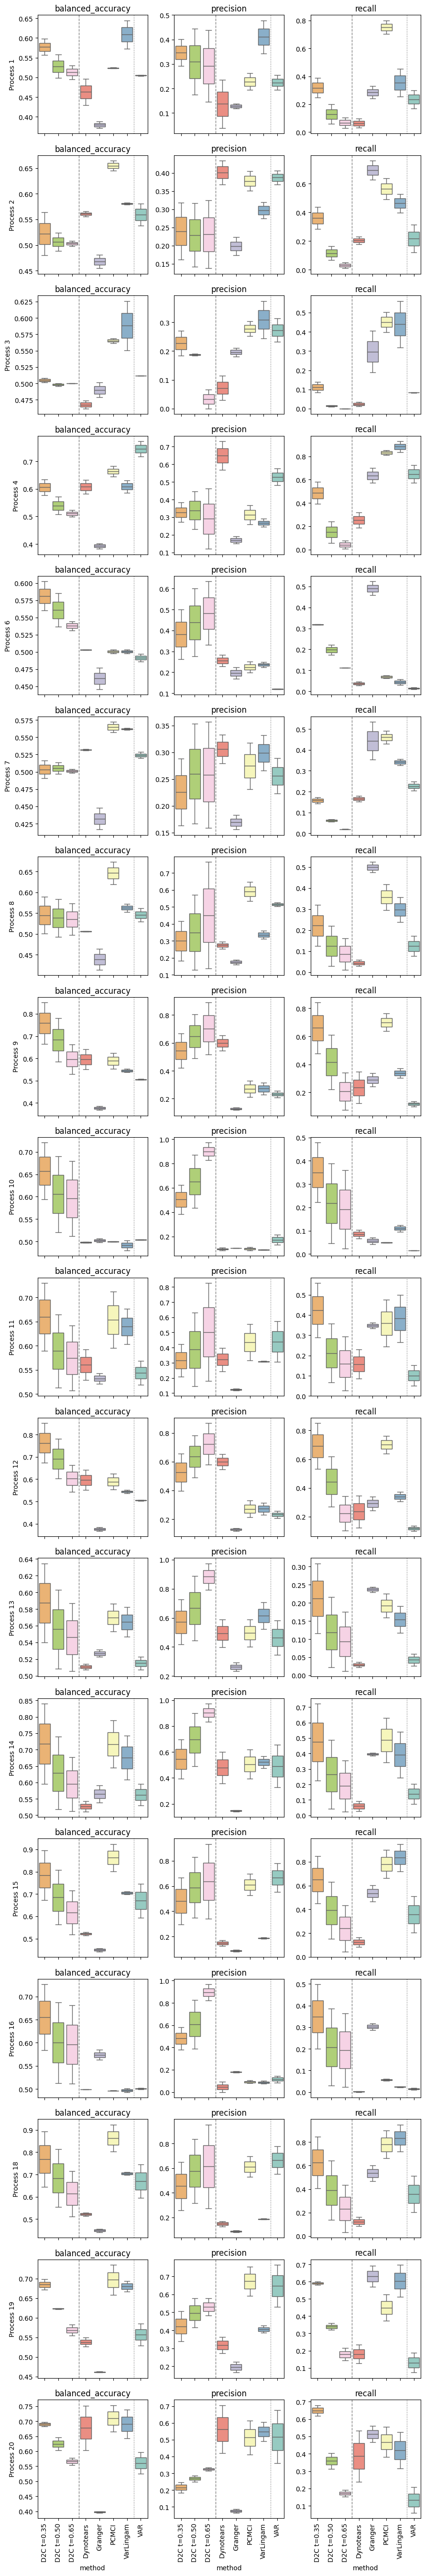

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create boxplots for each metric and process, adjusting the subplot creation to handle any issues

# Get unique processes and metrics to plot
n_variables = scores['process'].unique()
metrics = ['balanced_accuracy', 'precision', 'recall']

method_order = sorted(set(scores['method']) - {'VAR'}) + ['VAR']

# Create a figure large enough to accommodate all plots
fig, axes = plt.subplots(nrows=len(n_variables), ncols=3, figsize=(9, 3*len(n_variables)), sharex='col')

# Use a loop to generate boxplots for each combination of process and metric
for j, metric in enumerate(metrics):
    for i, process in enumerate(sorted(n_variables)):
        sns.boxplot(ax=axes[i, j], x='method', y=metric, data=scores[scores['process'] == process],order=method_order, palette='Set3',hue='method')

        var_index = method_order.index('VAR')
        axes[i, j].axvline(x=var_index - 0.5, color='gray', linestyle='dotted', linewidth=1)  # Dotted line

        var_index = method_order.index('D2C t=0.65')
        axes[i, j].axvline(x=var_index + 0.5, color='gray', linestyle='--', linewidth=1)  # Dotted line


        axes[i, j].tick_params(axis='x', rotation=90)
        axes[i, j].set_title(f'{metric}')
        if j == 0:
            axes[i, j].set_ylabel(f'Process {process}')
        else:
            axes[i, j].set_ylabel('')

# Adjust the layout for better visibility
plt.tight_layout()
plt.show()


In [38]:
scores[scores['n_variables'] == N]

,process,n_variables,nj_size,noise,method,accuracy,balanced_accuracy,precision,recall,f1,test_size,positive_size
0,10,5,8,0.005,VAR,0.8814,0.504185,0.214286,0.015817,0.029460,5000,569
1,10,5,8,0.005,PCMCI,0.8496,0.500029,0.113924,0.047452,0.066998,5000,569
2,10,5,8,0.005,Granger,0.8498,0.497844,0.104348,0.042179,0.060075,5000,569
3,10,5,8,0.005,Dynotears,0.7998,0.496440,0.107273,0.103691,0.105451,5000,569
4,10,5,8,0.005,VarLingam,0.7544,0.480016,0.088639,0.124780,0.103650,5000,569
...,...,...,...,...,...,...,...,...,...,...,...,...
229,8,5,8,0.005,D2C t=0.50,0.7726,0.583903,0.569892,0.220466,0.317936,5000,1202
230,8,5,8,0.005,D2C t=0.65,0.7864,0.572800,0.763780,0.161398,0.266484,5000,1202
231,9,5,8,0.005,D2C t=0.35,0.8562,0.851780,0.666454,0.842995,0.744401,5000,1242
232,9,5,8,0.005,D2C t=0.50,0.8666,0.781074,0.804878,0.611111,0.694737,5000,1242


In [39]:
n_variables = scores['n_variables'].unique()
n_variables

array([ 5, 10])

In [40]:
len(n_variables)

2

AttributeError: 'numpy.ndarray' object has no attribute 'yaxis'

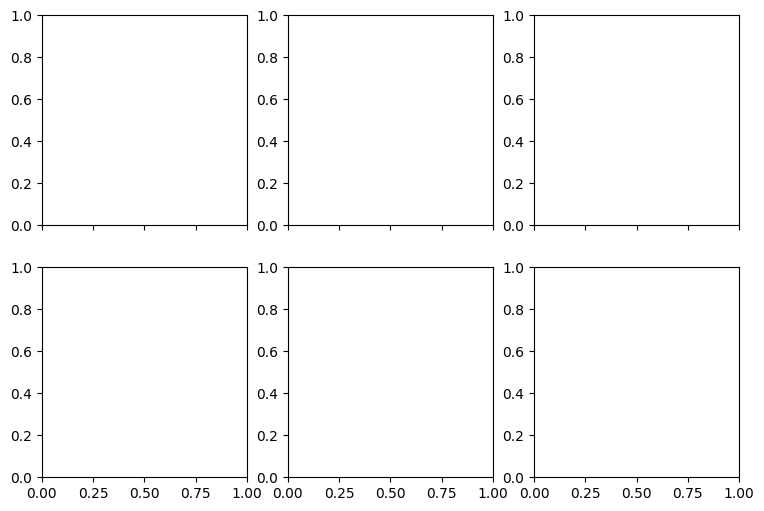

In [41]:
# Create boxplots for each metric and process, adjusting the subplot creation to handle any issues
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique processes and metrics to plot
n_variables = scores['n_variables'].unique()
metrics = ['balanced_accuracy', 'precision', 'recall']
mapping_metric = {'balanced_accuracy':'Balanced Accuracy', 'precision':'Precision', 'recall':'Recall'}
method_order = sorted(set(scores['method']) - {'VAR'}) + ['VAR']
# Create a figure large enough to accommodate all plots
fig, axes = plt.subplots(nrows=len(n_variables), ncols=3, figsize=(9, 3*len(n_variables)), sharex='col')

# Use a loop to generate boxplots for each combination of process and metric
for j, metric in enumerate(metrics):
    for i, N in enumerate(sorted(n_variables)):
        # sns.boxplot(ax=axes[i, j], x='method', y=metric, data=scores[scores['n_variables'] == N], order=method_order,palette='Set3',hue='method')
        ax_ref = axes[j] #axes[i, j] in the multidimensional case
        sns.boxplot(ax=ax_ref, x='method', y=metric, data=scores[scores['n_variables'] == N], order=method_order,palette='Set3',hue='method')
        
        ax_ref.tick_params(axis='x', rotation=90)
        ax_ref.set_title(f'{mapping_metric[metric]}')

        var_index = method_order.index('VAR')
        ax_ref.axvline(x=var_index - 0.5, color='gray', linestyle='dotted', linewidth=1)

        var_index = method_order.index('D2C t=0.65')
        ax_ref.axvline(x=var_index + 0.5, color='gray', linestyle='--', linewidth=1)  # Dotted line
        
        if j == 0:
            ax_ref.set_ylabel(f'N {N}')
        else:
            ax_ref.set_ylabel('')

# Adjust the layout for better visibility
plt.tight_layout()
plt.show()


# Compute relative metrics (difference wrt VAR)

In [24]:
import pandas as pd

# Define the metrics and methods
metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
method_order = sorted(set(scores['method']) - {'VAR'})

# Prepare a new DataFrame to store results
results = pd.DataFrame()

# Iterate over each group
for (idx, group) in scores.groupby(['process', 'n_variables', 'nj_size', 'noise']):
    # Extract VAR scores for the current group
    var_scores = group[group['method'] == 'VAR']

    # Use the transform function to broadcast the VAR scores across the corresponding entries
    for metric in metrics:
        group[f'{metric}_diff'] = group.apply(lambda row: row[metric] - var_scores[metric].values[0] if row['method'] != 'VAR' else None, axis=1)

    # Append the modified group to the results DataFrame
    results = pd.concat([results, group])

# Optionally, you can filter out the VAR method if you only need the differences
results = results[results['method'] != 'VAR']



In [25]:

print(results.head())

     process  n_variables  nj_size  noise      method  accuracy  \
46         1            5        8  0.005       PCMCI    0.3874   
47         1            5        8  0.005     Granger    0.4372   
48         1            5        8  0.005   Dynotears    0.7202   
49         1            5        8  0.005   VarLingam    0.6994   
117        1            5        8  0.005  D2C t=0.35    0.7030   

     balanced_accuracy  precision  recall        f1  test_size  positive_size  \
46            0.525200   0.262385  0.8008  0.395262       5000           1250   
47            0.371467   0.138632  0.2400  0.175747       5000           1250   
48            0.506800   0.286533  0.0800  0.125078       5000           1250   
49            0.584400   0.388938  0.3544  0.370866       5000           1250   
117           0.597467   0.402165  0.3864  0.394125       5000           1250   

     accuracy_diff  balanced_accuracy_diff  precision_diff  recall_diff  \
46         -0.2198                0

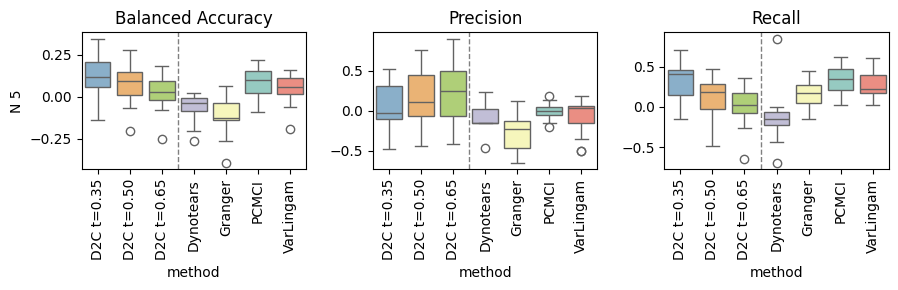

In [27]:
# Create boxplots for each metric and process, adjusting the subplot creation to handle any issues
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique processes and metrics to plot
n_variables = results['n_variables'].unique()
metrics = ['balanced_accuracy_diff', 'precision_diff', 'recall_diff']
mapping_metric = {'balanced_accuracy_diff':'Balanced Accuracy', 'precision_diff':'Precision', 'recall_diff':'Recall'}
method_order = sorted(set(results['method']) - {'VAR'}) 
# Create a figure large enough to accommodate all plots
fig, axes = plt.subplots(nrows=len(n_variables), ncols=3, figsize=(9, 3*len(n_variables)), sharex='col')

# Use a loop to generate boxplots for each combination of process and metric
for j, metric in enumerate(metrics):
    for i, N in enumerate(sorted(n_variables)):
        ax_ref = axes[j] #axes[i, j] in the multidimensional case
        sns.boxplot(ax=ax_ref, x='method', y=metric, data=results[results['n_variables'] == N], order=method_order,palette='Set3',hue='method')
        ax_ref.tick_params(axis='x', rotation=90)
        ax_ref.set_title(f'{mapping_metric[metric]}')

        var_index = method_order.index('D2C t=0.65')
        ax_ref.axvline(x=var_index + 0.5, color='gray', linestyle='--', linewidth=1)  # Dotted line
        
        if j == 0:
            ax_ref.set_ylabel(f'N {N}')
        else:
            ax_ref.set_ylabel('')

# Adjust the layout for better visibility
plt.tight_layout()
plt.show()
